In [1]:
import pathlib
import os
if not "changed_working_directory" in locals():
    changed_working_directory = True
    os.chdir(pathlib.Path().resolve().parent)
    
%load_ext autoreload
%autoreload 2

from tabGAN import TabGAN, TabGANcf, TabGANcfmc
from src import constants as const
import helpers
import scipy

imports_path = "src//imports.ipynb"
tabGAN_path = "tabGAN.py"
utils_path = "utils\\utils.ipynb"

%run "$imports_path"

if const.dir.project() != os.getcwd():
    raise ValueError("Project directory not the same as in global vars")

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inp1 = keras.Input(shape=(10))
inp2 = keras.Input(shape=(20))
inp3 = keras.Input(shape=(40))
inp4 = keras.Input(shape=(1))
hidden = layers.concatenate([inp1, inp2, inp3])
output = Dense(1, name="output_critic")(hidden)
model2 = Model(inputs=[inp1, [inp2, inp3], inp4], outputs=output)

2022-05-06 11:22:23.333068: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


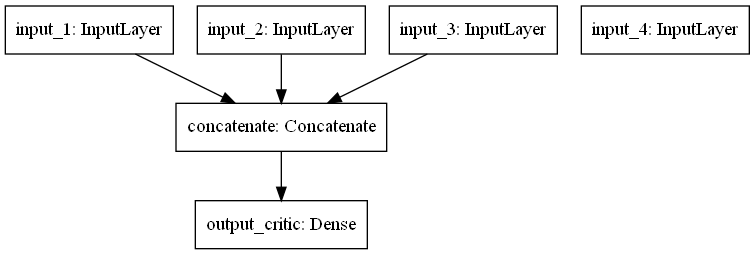

In [3]:
keras.utils.plot_model(model2)

In [4]:
model2([tf.random.normal([1, 10]), [tf.random.normal([1, 20]), tf.random.normal([1, 40])]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.48284447]], dtype=float32)>

In [5]:
[1] + [None]

[1, None]

In [9]:
[i if i < 5 else None for i in range(10)]

[0, 1, 2, 3, 4, None, None, None, None, None]

In [6]:
n_epochs = 20
n_critic = 10
opt_lr = 0.0002
adam_beta1 = 0.5
noise_discrete_unif_max = 0

batch_size = 500
ckpt_every = 1
loss_plot_update_every = 10

retrain = True

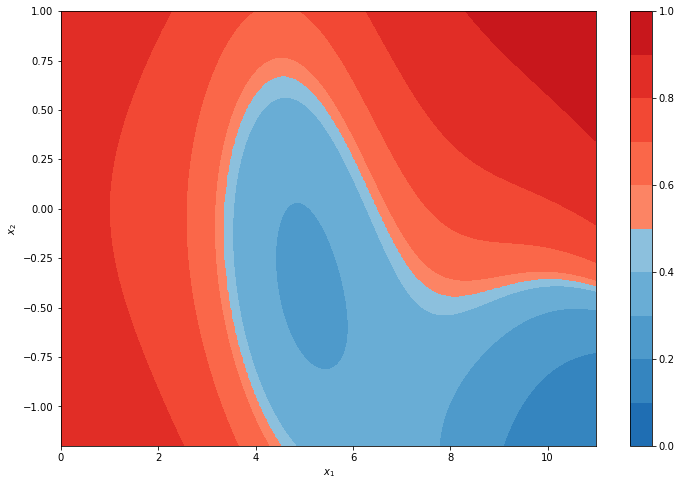

In [7]:
n_cols = 10
# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = matplotlib.cm.get_cmap('Blues_r')(np.linspace(0.2, 0.6, n_cols))
colors2 = matplotlib.cm.get_cmap('Reds')(np.linspace(0.4, 0.8, n_cols))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap_br = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

def classifier_func(x1, x2):
    a = 0.1 * (x1 - 5)**2 + (x2)**2 - 0.5 + 0.2 * tf.sqrt(x1) - 0.1*x1 + 0.005*x1**3 * x2 + 0.5*tf.math.sin(x1) + 0.3*tf.math.cos(x2)
    b = tf.sign(a) * (tf.abs(a))**(1/2)
    return tf.math.sigmoid(b)


fig, ax = plt.subplots(figsize=[12,8])
def plot_heatmap(ax, heat_map_res = 200, incl_axis_labels = True, incl_colorbar = True, ret_contour = True):
    x1 = np.linspace(0, 11, heat_map_res)
    x2 = np.linspace(-1.2, 1, heat_map_res)
    x1_mesh, x2_mesh = np.meshgrid(x1, x2)
    
    y_mesh = classifier_func(x1_mesh, x2_mesh)
    cont1 = ax.contourf(x1_mesh, x2_mesh, y_mesh, levels = np.linspace(0, 1, n_cols + 1), cmap = cmap_br)
    if (incl_axis_labels):
        ax.set_xlabel(r"$x_1$")
        ax.set_ylabel(r"$x_2$")
    if incl_colorbar:
        plt.colorbar(cont1, ax = ax)
    if ret_contour:
        return cont1

plot_heatmap(ax)
plt.savefig(os.path.join(const.dir.images(), "prediction_func_for_cf_testing.svg"))

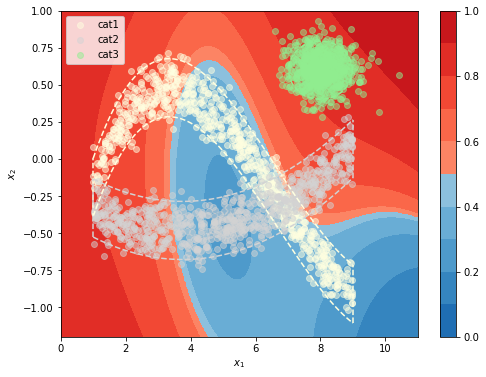

In [8]:
def classifier(data):
    return(classifier_func(data["x1"], data["x2"]))

n_train = 5000

x1_low, x1_high = 1,9
np.random.seed(1)

def sample_x1_given_x3(x3):
    x1_given_cat1_or_cat2 = np.random.uniform(x1_low, x1_high, n_train)
    x1_given_cat3 = np.random.normal(x1_mean_given_x3, sigma_x1 , n_train)
    return np.where(x3 == "cat3", x1_given_cat3, x1_given_cat1_or_cat2)

sigma_x2 = 0.1
sigma_x1 = 0.5
x3 = np.random.choice(["cat1","cat2", "cat3"], n_train)
x1_mean_given_x3 = 8
x2_mean_given_x3 = 0.6
x1 = sample_x1_given_x3(x3)

def mean_x2_given_x1_x3(x1, x3):
    cond_list = [x3 == "cat1", x3 == "cat2", x3 == "cat3"]
    choice_list = [0.01*(x1)**3 - 0.2*x1**2 + x1 - 1, 0.02*x1**2 - 0.15*x1 -0.2, x2_mean_given_x3]
    return np.select(cond_list, choice_list, default=0)

def sample_x2_given_x1_x3(x1,x3, sigma):
    return np.random.normal(mean_x2_given_x1_x3(x1, x3), sigma, n_train)

def conf_int_x2_given_x1_x3(x3, sigma_x1, sigma_x2, alpha = 0.05, n_steps = 100):
    if x3 == "cat1" or x3 == "cat2":
        x1 = np.linspace(x1_low, x1_high, n_steps)
        mean = mean_x2_given_x1_x3(x1, x3)
        return(x1, scipy.stats.norm.interval(1-alpha, loc=mean, scale=sigma_x2))
    elif x3 == "cat3":
        degree = np.linspace(0, np.pi, n_steps)
        x1 = x1_mean_given_x3 + np.cos(degree) * 1.96 *sigma_x1
        x2 = [x2_mean_given_x3 + np.sin(degree) * 1.96 * sigma_x2,
              x2_mean_given_x3 + np.sin(-degree) * 1.96 * sigma_x2]
        return x1, x2
    else:
        raise ValueError("The x3 paramter must be one of the values cat1, cat2 or cat3 and given in string format")

x2 = sample_x2_given_x1_x3(x1, x3, sigma_x2)
df_toy = pd.DataFrame({"x1" : x1, "x2" : x2, "x3" : x3})
df_toy.to_csv(os.path.join(const.dir.data(), "df_toy.csv"), index=False)
category_colors = ["lightyellow", "lightgrey", "lightgreen"]

def plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2, alpha = 0.05):
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat1", sigma_x1, sigma_x2, alpha =alpha)
    ax.plot(x1_grid, x2_confint[0], c= category_colors[0], linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = category_colors[0], linestyle = "dashed")
    ax.plot([x1_grid[0], x1_grid[0]], [x2_confint[0][0], x2_confint[1][0]],
            c=category_colors[0], linestyle = "dashed")
    ax.plot([x1_grid[-1], x1_grid[-1]], [x2_confint[0][-1], x2_confint[1][-1]],
            c=category_colors[0], linestyle = "dashed")
    
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat2", sigma_x1, sigma_x2, alpha = alpha)
    ax.plot(x1_grid, x2_confint[0], c= category_colors[1], linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = category_colors[1], linestyle = "dashed")
    ax.plot([x1_grid[0], x1_grid[0]], [x2_confint[0][0], x2_confint[1][0]],
            c=category_colors[1], linestyle = "dashed")
    ax.plot([x1_grid[-1], x1_grid[-1]], [x2_confint[0][-1], x2_confint[1][-1]],
            c=category_colors[1], linestyle = "dashed")
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat3", sigma_x1, sigma_x2, alpha=alpha)
    ax.plot(x1_grid, x2_confint[0], c=category_colors[2], linestyle="dashed")
    ax.plot(x1_grid, x2_confint[1], c=category_colors[2], linestyle="dashed")
    
    

fig, ax = plt.subplots(figsize=[8,6])
map_x3_to_col = lambda x3 : np.select([x3 == "cat1", x3 == "cat2", x3 == "cat3"], category_colors)
categories_unique = np.unique(df_toy["x3"])
plot_heatmap(ax)
for i, cat in enumerate(categories_unique):
    df_toy_subset = df_toy.loc[df_toy["x3"] == cat].head(750)
    plt.scatter(df_toy_subset["x1"], df_toy_subset["x2"], color = str(map_x3_to_col(cat)), alpha = 0.5, label = cat)
plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)
plt.legend()
plt.savefig(os.path.join(const.dir.images(), "Syn2D_cf.svg"), dpi=300)

In [88]:
tgcf_mc = TabGANcfmc(df_toy, n_critic = n_critic, opt_lr = opt_lr, adam_beta1 = adam_beta1,
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

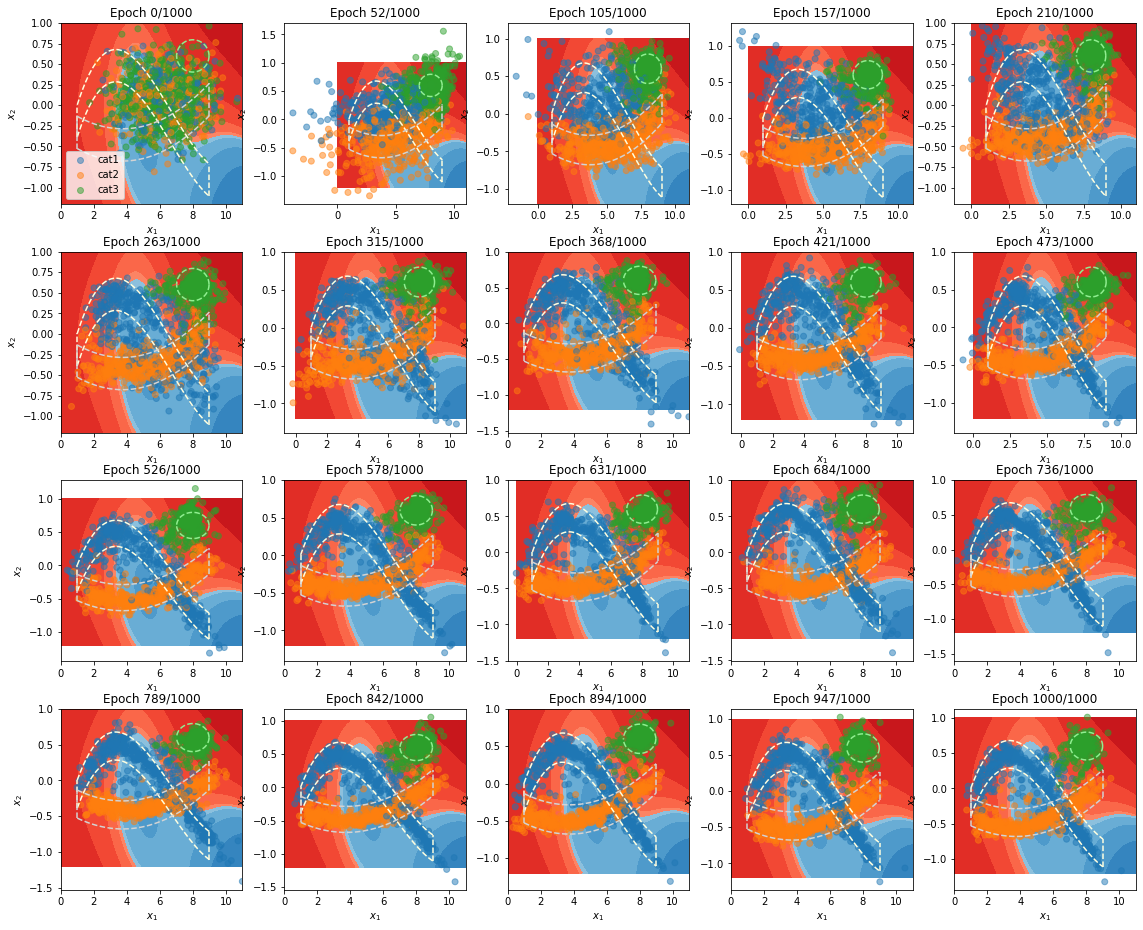

  0%|          | 0/1000 [00:00<?, ?it/s]

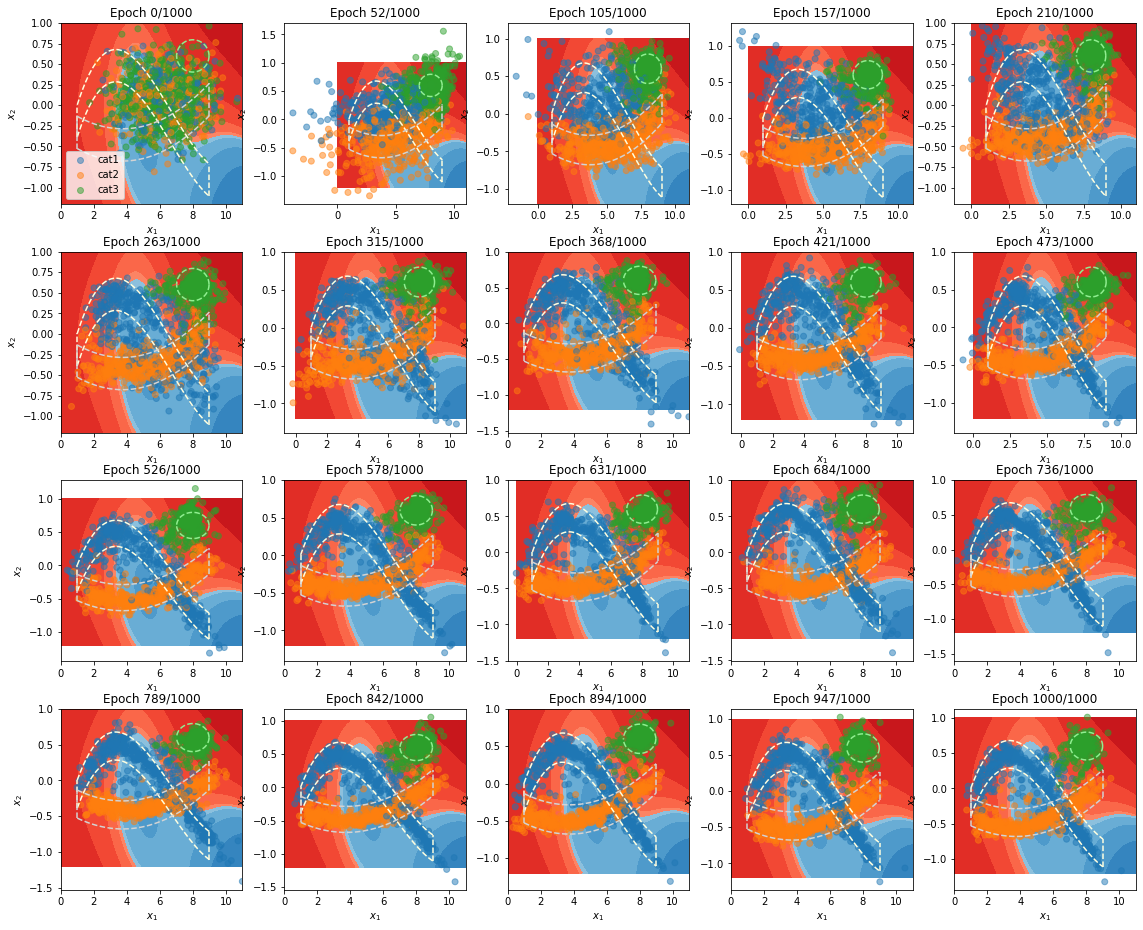

In [98]:
tgcf_mc.train(n_epochs = 1000, batch_size = 500, restart_training = True, plot_loss_update_every = loss_plot_update_every,
             plot_loss_type = "line", progress_bar=True, plot2D_image_real_time=True,
              plot_loss = False, plot2D_n_test=1500,
         plot2D_discrete_col="x3", save_dir = const.dir.images(), filename_plot2D = "syn2D_cf_plot2D.svg",
         filename_plot_loss = "syn2D_cf_train_loss.svg",
         plot2D_background_func = lambda ax : (plot_heatmap(ax, incl_colorbar = False, ret_contour = False),
                                               plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)))

In [34]:
tgcf = TabGANcf(df_toy, classifier=classifier, n_critic = n_critic, opt_lr = opt_lr, adam_beta1 = adam_beta1,
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

In [43]:
tgcf.split_transformed_data(tgcf.generate_queries(5))

(<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
 array([[-1.5174819 , -1.1562712 ],
        [ 1.0199142 ,  1.2481688 ],
        [-0.00600167, -0.7498557 ],
        [ 0.41354087, -0.9403456 ],
        [-0.9427903 , -0.9908328 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=float32)>)

In [45]:
tgcf.inv_data_transform(*tgcf.split_transformed_data(tgcf.generate_queries(5)))

,x1,x2,x3
0,5.406117,0.180369,cat1
1,8.326979,-0.856347,cat1
2,7.275499,-0.090490,cat2
3,8.180646,0.458223,cat3
4,7.332776,0.412851,cat3


In [15]:
tgcf.classifier(tgcf.generate_queries(5))

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'x1'

In [120]:
a = tf.zeros(1)
a = tf.concat((a, [2]), axis=-1)
a

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 2.], dtype=float32)>

[1 3 7]


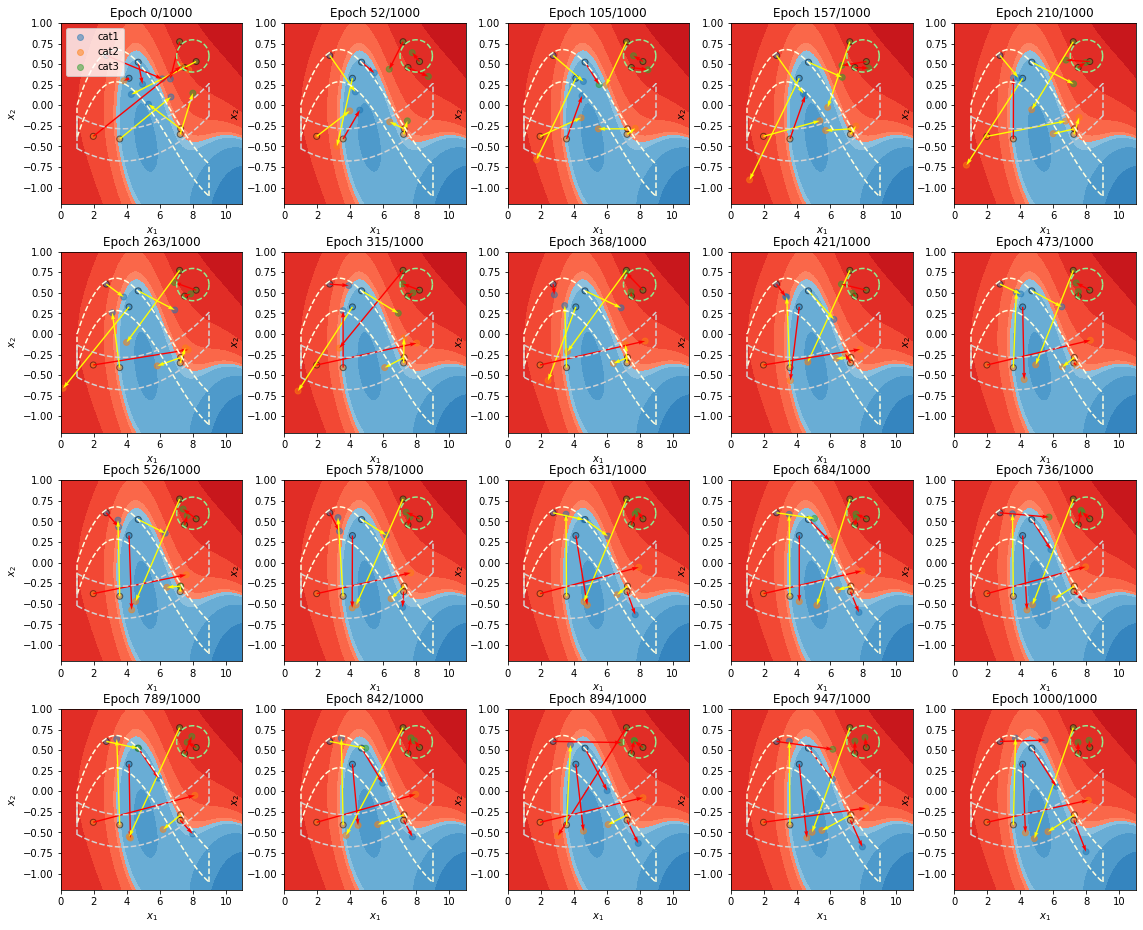

  0%|          | 0/1000 [00:00<?, ?it/s]

[-0.0721770301 1.44524372 0]
[-0.309890211 1.41380334 1.1920929e-07]
[-0.510219 1.36727381 5.96046448e-08]
[-0.6577245 1.40581763 0]
[-0.760487378 1.37588573 -5.96046448e-08]
[-0.816238403 1.44192219 0]
[-0.869926512 1.44988108 5.96046448e-08]
[-0.792339206 1.45716989 0]
[-0.733437657 1.48323739 0]
[-0.576034069 1.52360773 -5.96046448e-08]
[-0.442277491 1.4670074 0]
[-0.378876776 1.38860607 0]
[-0.326193631 1.35637975 0]
[-0.359580576 1.33763337 0]
[-0.38850078 1.30938184 0]
[-0.479297578 1.24782753 -5.96046448e-08]
[-0.561771333 1.25388777 0]
[-0.635906756 1.31433129 5.96046448e-08]
[-0.664940476 1.28905141 0]
[-0.695228636 1.2767365 0]
[-0.645593047 1.29415309 0]
[-0.632837534 1.24863672 0]
[-0.575502217 1.26585007 5.96046448e-08]
[-0.528226495 1.23273659 0]
[-0.583837688 1.20558989 0]
[-0.609300196 1.18393707 -5.96046448e-08]
[-0.676244438 1.20070887 -5.96046448e-08]
[-0.708318174 1.23216748 5.96046448e-08]
[-0.698607206 1.18780732 -5.96046448e-08]
[-0.67396754 1.19017816 5.96046448

[0.728525817 0.584397137 0]
[0.705558479 0.573839247 0]
[0.698045433 0.588994801 0]
[0.723809659 0.575301468 0]
[0.714051366 0.587674618 0]
[0.701026797 0.572568536 0]
[0.704033911 0.582499564 0]
[0.740571558 0.558350742 0]
[0.677648544 0.591488957 0]
[0.728756428 0.570238829 0]
[0.716005504 0.571417391 0]
[0.694649875 0.573060811 0]
[0.725426257 0.574143708 0]
[0.700265706 0.585021794 0]
[0.733735502 0.558321416 0]
[0.720311642 0.588013649 0]
[0.745549619 0.548086 0]
[0.712785661 0.573539555 0]
[0.721405745 0.571885943 0]
[0.766425 0.561434627 0]
[0.748316765 0.544696331 0]
[0.724237 0.560146034 0]
[0.68541342 0.578252375 0]
[0.759469688 0.562321603 0]
[0.748595238 0.539233327 0]
[0.72186172 0.572452903 0]
[0.748631418 0.561289132 0]
[0.716075301 0.580038548 0]
[0.731356442 0.579891 0]
[0.753336 0.54424125 0]
[0.741377294 0.548927 0]
[0.715666175 0.570877314 0]
[0.720989 0.560608387 0]
[0.729956 0.574341 0]
[0.690825641 0.577777565 0]
[0.724807 0.573410034 0]
[0.665181637 0.583560467 

[0.281314403 0.597922206 0]
[0.23931092 0.626480401 0]
[0.275928289 0.607632637 0]
[0.224845752 0.64500612 0]
[0.264464378 0.626115918 0]
[0.22703059 0.64749819 0]
[0.209062696 0.650121689 0]
[0.2234485 0.627470672 0]
[0.19735007 0.6369735 0]
[0.279363185 0.592263341 0]
[0.255090624 0.620715618 0]
[0.239991 0.581310451 0]
[0.256491661 0.60193485 0]
[0.229330927 0.616915107 5.96046448e-08]
[0.254724979 0.626850605 0]
[0.232365012 0.587006807 0]
[0.239950567 0.616013765 5.96046448e-08]
[0.195210204 0.645332336 0]
[0.235757425 0.615591 0]
[0.265820771 0.603372574 0]
[0.294476241 0.591190338 -5.96046448e-08]
[0.1956359 0.631791234 0]
[0.196182802 0.624709964 0]
[0.199548066 0.62551564 0]
[0.190750703 0.651202679 0]
[0.21570076 0.611505 0]
[0.187529132 0.653326809 0]
[0.17098102 0.649130583 0]
[0.181086704 0.624657691 0]
[0.156570777 0.607715607 0]
[0.186645761 0.624581099 0]
[0.212663457 0.626166642 0]
[0.200857863 0.595603585 0]
[0.172546372 0.643198967 0]
[0.230921417 0.606787682 0]
[0.1

[-0.34303686 0.652561069 2.98023224e-08]
[-0.353127122 0.662430167 0]
[-0.402473748 0.688207328 0]
[-0.425569445 0.683678269 2.98023224e-08]
[-0.371515453 0.684348643 0]
[-0.356342 0.677644 -2.98023224e-08]
[-0.453983 0.725588441 2.98023224e-08]
[-0.327148139 0.631365478 0]
[-0.367203444 0.674579144 2.98023224e-08]
[-0.33929652 0.632737756 2.98023224e-08]
[-0.399035 0.662104487 2.98023224e-08]
[-0.38146925 0.680838585 0]
[-0.366867 0.647424698 0]
[-0.454147518 0.737270534 0]
[-0.396840453 0.657024682 0]
[-0.38106516 0.640548944 -2.98023224e-08]
[-0.392846912 0.679731 -2.98023224e-08]
[-0.385398328 0.694545686 0]
[-0.379523695 0.650288522 0]
[-0.448739022 0.685332656 1.49011612e-08]
[-0.415099978 0.707439959 0]
[-0.372535467 0.647589326 -2.98023224e-08]
[-0.406272024 0.676582634 0]
[-0.371955603 0.640170932 -2.98023224e-08]
[-0.412214458 0.682338893 0]
[-0.414060473 0.696015835 -2.98023224e-08]
[-0.405457467 0.675908208 2.98023224e-08]
[-0.415723354 0.673555851 0]
[-0.455578744 0.694649

[-0.86941272 0.723538876 0]
[-0.797382116 0.68427968 -1.49011612e-08]
[-0.798369288 0.670218766 1.49011612e-08]
[-0.81118089 0.71218431 2.98023224e-08]
[-0.837611556 0.683522224 -2.98023224e-08]
[-0.86166203 0.762817204 1.49011612e-08]
[-0.835316181 0.733117938 1.49011612e-08]
[-0.777567446 0.665269256 1.49011612e-08]
[-0.845490694 0.713052273 -2.98023224e-08]
[-0.862300754 0.718992651 1.49011612e-08]
[-0.821754873 0.70595789 -2.98023224e-08]
[-0.833029568 0.719880044 -1.49011612e-08]
[-0.860314429 0.71079123 -2.98023224e-08]
[-0.842660308 0.737028301 1.49011612e-08]
[-0.84193927 0.721660495 -2.98023224e-08]
[-0.822867692 0.706266165 0]
[-0.873355269 0.72264272 -1.49011612e-08]
[-0.883384347 0.751135409 1.49011612e-08]
[-0.914597631 0.734096646 1.49011612e-08]
[-0.821647763 0.689874232 -1.49011612e-08]
[-0.912875235 0.728557 1.49011612e-08]
[-0.871803522 0.732108235 2.98023224e-08]
[-0.803758323 0.689606 -1.49011612e-08]
[-0.858482361 0.690290928 -1.49011612e-08]
[-0.941326201 0.763499

[-1.35175872 0.730270624 0]
[-1.4038614 0.77302 0]
[-1.31404746 0.726259112 0]
[-1.35123289 0.782978892 0]
[-1.31604779 0.753245473 0]
[-1.32127893 0.74236542 0]
[-1.39662361 0.782995522 0]
[-1.34941745 0.727025747 0]
[-1.375862 0.774143279 0]
[-1.30458951 0.719822645 0]
[-1.39073 0.759180427 0]
[-1.38212597 0.76933378 0]
[-1.38629138 0.771408558 0]
[-1.34745204 0.755574882 0]
[-1.4372896 0.774588823 0]
[-1.39455187 0.790894866 0]
[-1.39229548 0.754181862 0]
[-1.39654088 0.76706481 0]
[-1.3991648 0.785641909 0]
[-1.39826739 0.767689884 0]
[-1.39324808 0.769360304 0]
[-1.41807163 0.762435317 0]
[-1.40922487 0.801695406 0]
[-1.35469699 0.731778264 0]
[-1.41755033 0.744886756 0]
[-1.43810606 0.786968291 0]
[-1.4329921 0.760070205 0]
[-1.41988575 0.721267521 0]
[-1.42290938 0.763671339 0]
[-1.43090045 0.74928844 0]
[-1.49032176 0.812530935 0]
[-1.40171957 0.726922154 0]
[-1.40151072 0.750067711 0]
[-1.40511453 0.723225653 0]
[-1.44533515 0.771964133 0]
[-1.52460468 0.797732472 0]
[-1.45371

[-2.16303682 0.862666488 0]
[-2.2053175 0.845104218 0]
[-2.13840318 0.832804203 0]
[-2.17135835 0.848487 0]
[-2.19440508 0.835671425 0]
[-2.21056032 0.89456737 0]
[-2.17966223 0.825087309 0]
[-2.12627459 0.782129049 0]
[-2.21220374 0.84786 0]
[-2.15378976 0.810055 0]
[-2.14894462 0.840639234 0]
[-2.22597742 0.869546056 0]
[-2.20591211 0.853141785 0]
[-2.16022682 0.830693483 0]
[-2.1812098 0.848567128 0]
[-2.14094281 0.805367112 0]
[-2.12395048 0.783129692 0]
[-2.20610595 0.860316157 0]
[-2.1423409 0.791205168 0]
[-2.1885829 0.86525476 0]
[-2.17176247 0.832244754 0]
[-2.13850975 0.855637789 0]
[-2.16856503 0.830234766 0]
[-2.18822145 0.851827145 0]
[-2.28322577 0.895957947 0]
[-2.2259562 0.882223129 0]
[-2.23215699 0.840001106 0]
[-2.20780754 0.864029288 0]
[-2.2074368 0.831910491 0]
[-2.21076894 0.880521297 0]
[-2.17633033 0.834358931 0]
[-2.16884351 0.822609663 0]
[-2.22700644 0.861263633 0]
[-2.17850184 0.827979207 0]
[-2.26124 0.884606719 0]
[-2.21610379 0.821305394 0]
[-2.26155782 

[-2.90049887 0.941779852 0]
[-2.91220927 1.00148904 0]
[-2.85485721 0.891900897 0]
[-2.91977501 0.921723366 0]
[-2.89461112 0.938192368 0]
[-2.89959717 0.881632328 0]
[-2.86777401 0.955284119 0]
[-2.8228116 0.881226301 0]
[-2.93167639 0.973207474 0]
[-2.93860507 0.934304953 0]
[-2.91736102 0.935998797 0]
[-2.86547 0.922215223 0]
[-2.90317631 0.944868565 0]
[-2.9205606 0.945136547 0]
[-2.96601057 0.920158625 0]
[-2.89378715 0.953646541 0]
[-3.02385926 1.00133443 0]
[-2.93215251 0.907099962 0]
[-2.94099689 0.93031621 0]
[-2.91459465 0.927449703 0]
[-2.99086499 0.949153662 0]
[-2.94070339 0.873888493 0]
[-2.90460491 0.919416428 0]
[-2.83150458 0.886583328 0]
[-2.9786377 0.912744761 0]
[-2.89869356 0.888011 0]
[-3.01982284 0.956380844 0]
[-2.9726789 0.95090723 0]
[-2.88966513 0.900200605 0]
[-2.9536624 0.90638113 0]
[-2.99107265 0.928788424 0]
[-2.93932676 0.903327465 0]
[-2.94178367 0.923105 0]
[-2.96589541 0.930597067 0]
[-2.95601845 0.897406578 0]
[-2.97967315 0.94928813 0]
[-2.98420453

[-3.6391077 1.04311872 0]
[-3.6039083 0.966719866 0]
[-3.59362888 0.978408813 0]
[-3.64057088 1.0266614 0]
[-3.62633967 0.993645191 0]
[-3.67240262 1.0553062 0]
[-3.52249718 0.909780264 0]
[-3.62102485 0.975326777 0]
[-3.65145612 0.988574505 0]
[-3.6197691 0.96968317 0]
[-3.63730335 0.988920212 0]
[-3.57932353 0.973776102 0]
[-3.60481548 0.975930691 0]
[-3.5558784 0.934048891 0]
[-3.67602253 1.04987144 0]
[-3.54700494 0.943276167 0]
[-3.63345599 0.99314785 0]
[-3.63807034 1.00082064 0]
[-3.64704609 1.00624967 0]
[-3.71745563 1.0166223 0]
[-3.66116524 0.993854523 0]
[-3.5594058 0.925475597 0]
[-3.58620977 0.94427371 0]
[-3.64292812 0.961174965 0]
[-3.58666039 0.930290699 0]
[-3.57629061 0.953401566 0]
[-3.71734023 1.00396442 0]
[-3.64592218 0.982245445 0]
[-3.60884786 0.954422235 0]
[-3.67548132 1.03518629 0]
[-3.67910194 1.0178442 0]
[-3.58564377 0.964491129 0]
[-3.70506239 0.998624325 0]
[-3.65230441 0.976420641 0]
[-3.68086958 1.00150967 0]
[-3.64628577 0.992406607 0]
[-3.66980386 0.

[-4.31544209 1.04497576 0]
[-4.21923399 0.976786375 0]
[-4.22681952 1.01290226 0]
[-4.18432 0.970978 0]
[-4.24629593 1.00748563 0]
[-4.22242069 0.98858285 0]
[-4.27987 1.04841232 0]
[-4.25159073 1.01591563 0]
[-4.2065115 0.989845753 0]
[-4.33042479 1.03584552 0]
[-4.24887371 0.974856138 0]
[-4.21233845 1.02463055 0]
[-4.25050592 1.0313406 0]
[-4.23667192 1.00511122 0]
[-4.25424719 1.00445366 0]
[-4.33375692 1.0728972 0]
[-4.26958704 0.978194714 0]
[-4.21156883 0.973720789 0]
[-4.23045588 0.982542515 0]
[-4.24668121 1.02677655 0]
[-4.30038166 1.03112316 0]
[-4.21316671 0.960813522 0]
[-4.26242924 0.967041492 0]
[-4.27973557 1.01504898 0]
[-4.28410101 1.04138184 0]
[-4.31180239 1.02311826 0]
[-4.21601534 0.964381456 0]
[-4.28676271 0.973215342 0]
[-4.32316923 0.957839727 0]
[-4.29074287 0.994467 0]
[-4.29560947 1.00439572 0]
[-4.28114653 0.994893789 0]
[-4.30036545 0.983045101 0]
[-4.32524395 1.05531311 0]
[-4.25612497 0.956514835 0]
[-4.31274652 1.00144982 0]
[-4.22689676 0.961399078 0]

[-4.8718 1.0348053 0]
[-4.87681341 1.06434226 0]
[-4.84869719 1.0056026 0]
[-4.89342976 1.03037643 0]
[-4.92623615 1.0746448 0]
[-4.84911442 0.985675335 0]
[-4.85789251 0.973391294 0]
[-4.88094091 0.973883152 0]
[-4.86303091 0.990103483 0]
[-4.91091061 1.02820182 0]
[-4.92048788 1.02631831 0]
[-4.86654329 0.984930038 0]
[-4.96286392 1.07001638 0]
[-4.81099844 0.960061789 0]
[-4.88446569 0.976630688 0]
[-4.9311 1.03481126 0]
[-4.89665031 1.01502037 0]
[-4.92891312 1.04170799 0]
[-4.86676502 0.987355471 0]
[-4.89105749 1.00469184 0]
[-4.90831423 1.0138514 0]
[-4.87050056 0.99442625 0]
[-4.91121817 1.0247407 0]
[-4.89850187 1.02934313 0]
[-4.94402266 1.02158046 0]
[-4.96272 1.04134703 0]
[-4.98144102 1.06250763 0]
[-4.93384933 1.03277588 0]
[-4.98397446 1.09844232 0]
[-4.99908829 1.07597566 0]
[-4.96428871 1.05054235 0]
[-4.88935184 0.942530632 0]
[-4.96461439 1.0534637 0]
[-4.95719242 1.04232621 0]
[-4.98328924 1.04022288 0]
[-4.98914814 1.02318907 0]
[-4.95365143 1.02337027 0]
[-4.93710

[-5.53181505 1.08470726 0]
[-5.44041109 1.01178169 0]
[-5.4995532 1.00462389 0]
[-5.51087475 1.04524851 0]
[-5.56331778 1.05066586 0]
[-5.44628382 0.954211712 0]
[-5.53581429 1.04451895 0]
[-5.47442961 1.00432158 0]
[-5.43086147 0.964742661 0]
[-5.48894 1.01794243 0]
[-5.44236231 0.966639042 0]
[-5.5808959 1.08480644 0]
[-5.56652975 1.02115679 0]
[-5.5937686 1.06580257 0]
[-5.55408382 1.08241081 0]
[-5.57707453 1.0752368 0]
[-5.50568056 1.03521013 0]
[-5.51937056 1.05454302 0]
[-5.50785923 1.02004671 0]
[-5.57647371 1.06481218 0]
[-5.53679562 1.01304293 0]
[-5.56814337 1.06635666 0]
[-5.51516581 1.02135134 0]
[-5.602458 1.12209702 0]
[-5.47883 0.968174 0]
[-5.49658442 0.99393177 0]
[-5.52364 1.0072403 0]
[-5.63123274 1.13223553 0]
[-5.55482531 1.04527473 0]
[-5.53592396 1.00584698 0]
[-5.5271883 1.00278854 0]
[-5.60228395 1.0979104 0]
[-5.54761076 1.03142262 0]
[-5.61810446 1.0718379 0]
[-5.5461812 1.00482035 0]
[-5.59072542 1.04664469 0]
[-5.58387041 1.03894281 0]
[-5.61951256 1.08428

[-6.1180191 1.03045082 0]
[-6.06078148 1.00142431 0]
[-6.11505795 1.06692934 0]
[-6.12149286 1.0403924 0]
[-6.10916233 1.02611256 0]
[-6.17321396 1.09270668 0]
[-6.08952141 1.04082727 0]
[-6.2510891 1.12539291 0]
[-6.08530283 1.01111698 0]
[-6.13156176 1.04958105 0]
[-6.18253326 1.04916382 0]
[-6.06571388 1.02054739 0]
[-6.13126516 1.06677914 0]
[-6.09731 1.02728844 0]
[-6.19478703 1.08151484 0]
[-6.14642 1.05466366 0]
[-6.1540184 0.97838068 0]
[-6.20550776 1.07667255 0]
[-6.10897064 1.02061701 0]
[-6.21338129 1.10146809 0]
[-6.07592297 0.99597168 0]
[-6.13462734 1.04178953 0]
[-6.17913198 1.04432821 0]
[-6.20805311 1.04458475 0]
[-6.19960976 1.08356237 0]
[-6.13057613 1.00585318 0]
[-6.15537119 1.03666449 0]
[-6.16317177 1.01954031 0]
[-6.2428875 1.06903458 0]
[-6.15979052 1.03668261 0]
[-6.14051 1.02006245 0]
[-6.19790316 1.08208323 0]
[-6.20526314 1.06789207 0]
[-6.20334339 1.08051062 0]
[-6.21311712 1.07932901 0]
[-6.20911694 1.08362389 0]
[-6.22288036 1.07364416 0]
[-6.22977066 1.

[-6.78164148 1.03338385 0]
[-6.72259 1.01330185 0]
[-6.76309061 1.05256033 0]
[-6.79745293 1.05883169 0]
[-6.86953449 1.12851667 0]
[-6.79603624 1.08972883 0]
[-6.81399059 1.06194687 0]
[-6.74667168 1.02079248 0]
[-6.72366619 0.974823952 0]
[-6.80415297 1.09262133 0]
[-6.83544922 1.12927294 0]
[-6.80266094 1.03755665 0]
[-6.85010052 1.13532591 0]
[-6.78372335 1.04967022 0]
[-6.78313398 1.04949856 0]
[-6.83071518 1.08337212 0]
[-6.75101566 1.03406048 0]
[-6.75210428 1.01191139 0]
[-6.86061049 1.05891418 0]
[-6.93568373 1.16951942 0]
[-6.73777914 0.984427 0]
[-6.80228281 1.07386351 0]
[-6.77261972 1.06837368 0]
[-6.80413 1.07092714 0]
[-6.87531042 1.1018405 0]
[-6.85840082 1.11148357 0]
[-6.76244211 1.02117586 0]
[-6.83573103 1.08644915 0]
[-6.76517582 1.05156469 0]
[-6.83385706 1.04213858 0]
[-6.82214117 1.03493929 0]
[-6.81378508 1.09102964 0]
[-6.86513853 1.07162142 0]
[-6.88219 1.07526684 0]
[-6.84253836 1.09247112 0]
[-6.81040955 1.02593517 0]
[-6.87560272 1.09271812 0]
[-6.84240913

[-7.38104534 1.05982733 0]
[-7.40233183 1.07466316 0]
[-7.44143152 1.05799437 0]
[-7.37391663 1.02253342 0]
[-7.41379 1.07701206 0]
[-7.46354198 1.10151577 0]
[-7.38916063 1.07003498 0]
[-7.50961256 1.14830208 0]
[-7.49402046 1.15617704 0]
[-7.38455 1.05501699 0]
[-7.46778774 1.10268354 0]
[-7.48714256 1.12007332 0]
[-7.46993589 1.07265091 0]
[-7.46741915 1.08783579 0]
[-7.41166878 1.03585291 0]
[-7.54698086 1.12668657 0]
[-7.40388632 1.03658581 0]
[-7.43029404 1.07309294 0]
[-7.45011377 1.07656956 0]
[-7.46884203 1.11732197 0]
[-7.42831135 1.07261276 0]
[-7.51463366 1.12468052 0]
[-7.5020895 1.08205366 0]
[-7.51424551 1.12329912 0]
[-7.50348 1.10538626 0]
[-7.49425697 1.06792831 0]
[-7.45013523 1.05547523 0]
[-7.44536161 1.05244112 0]
[-7.52908182 1.13733101 0]
[-7.472929 1.04618931 0]
[-7.48744965 1.11857939 0]
[-7.43331337 0.995652676 0]
[-7.49497843 1.10780382 0]
[-7.4638319 1.06464624 0]
[-7.48956776 1.06747627 0]
[-7.49706459 1.06617165 0]
[-7.41954374 1.01352262 0]
[-7.50494671 

[-8.00422478 1.03621101 0]
[-8.04941368 1.10976982 0]
[-8.10479832 1.09283257 0]
[-8.05574894 1.12603903 0]
[-8.00707 1.02540112 0]
[-8.14103413 1.13082075 0]
[-8.08364677 1.07709074 0]
[-8.05818272 1.06433249 0]
[-8.06207943 1.03802824 0]
[-8.11580086 1.09739113 0]
[-8.12789726 1.12830734 0]
[-8.10292435 1.07289314 0]
[-8.09446239 1.10341406 0]
[-8.14468098 1.1226573 0]
[-8.11404514 1.11162281 0]
[-8.11180687 1.09965658 0]
[-8.06542397 1.05099249 0]
[-8.10185432 1.05800581 0]
[-8.08864212 1.04683018 0]
[-8.0771265 1.05907154 0]
[-8.06674767 1.04616928 0]
[-8.07294655 1.06797123 0]
[-8.03829765 1.02415466 0]
[-8.17394924 1.13520527 0]
[-8.12952137 1.09884977 0]
[-8.0586977 1.03274012 0]
[-8.1431 1.10650921 0]
[-8.11774731 1.0409956 0]
[-8.16537476 1.09675312 0]
[-8.20671082 1.14027643 0]
[-8.14663315 1.12065506 0]
[-8.15035725 1.06812286 0]
[-8.19112778 1.14492702 0]
[-8.139678 1.07330751 0]
[-8.05556583 1.02386618 0]
[-8.18098545 1.09804106 0]
[-8.11930847 1.01475096 0]
[-8.1680069 1.

[-8.69445324 1.07153082 0]
[-8.70071316 1.0787158 0]
[-8.76650143 1.11217642 0]
[-8.73304176 1.08419037 0]
[-8.7109623 1.10177803 0]
[-8.74355316 1.06664562 0]
[-8.71550083 1.09459496 0]
[-8.68172836 1.08625603 0]
[-8.68647289 1.04797745 0]
[-8.74885941 1.11831522 0]
[-8.66912174 1.04381561 0]
[-8.77082348 1.12395191 0]
[-8.77514553 1.14106178 0]
[-8.74604321 1.1293869 0]
[-8.77596 1.12476397 0]
[-8.82251358 1.17978621 0]
[-8.7508049 1.11122561 0]
[-8.79606342 1.11165619 0]
[-8.70335197 1.0899477 0]
[-8.69688225 1.03164864 0]
[-8.80777168 1.13604212 0]
[-8.71871567 1.06379271 0]
[-8.71408844 1.07056 0]
[-8.75909519 1.06627655 0]
[-8.79206276 1.11141396 0]
[-8.74435329 1.09029484 0]
[-8.84078598 1.16589355 0]
[-8.78513336 1.12103176 0]
[-8.74934673 1.06020832 0]
[-8.80155754 1.1298399 0]
[-8.76947498 1.1283021 0]
[-8.83085728 1.13044691 0]
[-8.81664944 1.10788202 0]
[-8.80481339 1.1656065 0]
[-8.81634712 1.15357304 0]
[-8.81216812 1.1405654 0]
[-8.80852795 1.07874441 0]
[-8.8345623 1.10

[-9.4192667 1.16459465 0]
[-9.39915752 1.11979389 0]
[-9.4046936 1.12594414 0]
[-9.30226898 1.01024628 0]
[-9.35643291 1.07410431 0]
[-9.38152122 1.08736324 0]
[-9.37462139 1.1378088 0]
[-9.4360323 1.13986397 0]
[-9.39524 1.13177013 0]
[-9.35334587 1.07245827 0]
[-9.42838383 1.14404774 0]
[-9.40696907 1.14607239 0]
[-9.35913754 1.07129383 0]
[-9.33173466 1.05388451 0]
[-9.39575768 1.09045887 0]
[-9.35203171 1.05688095 0]
[-9.46147346 1.16262627 0]
[-9.4171257 1.09787941 0]
[-9.35015 1.04757595 0]
[-9.38028 1.08625221 0]
[-9.41227531 1.10070515 0]
[-9.34622 1.06622791 0]
[-9.39762 1.07815552 0]
[-9.46016502 1.124856 0]
[-9.39953232 1.04944229 0]
[-9.44256496 1.12299252 0]
[-9.39810371 1.08727932 0]
[-9.52322865 1.2048502 0]
[-9.48024178 1.17478371 0]
[-9.34222603 1.00241184 0]
[-9.4543829 1.11039639 0]
[-9.41301155 1.10232544 0]
[-9.41884422 1.09411621 0]
[-9.4639492 1.10530281 0]
[-9.48833752 1.09083652 0]
[-9.3943634 1.09011269 0]
[-9.48696518 1.12872028 0]
[-9.40015125 1.09627819 0]


[-10.0308304 1.13959694 0]
[-9.95993519 1.06857491 0]
[-10.0481987 1.16121101 0]
[-10.0286179 1.0819788 0]
[-10.0408983 1.13530731 0]
[-10.0087652 1.11239529 0]
[-10.0153618 1.11937618 0]
[-10.0249319 1.10740852 0]
[-10.0278358 1.11791897 0]
[-10.0369415 1.14694881 0]
[-9.99324703 1.06433964 0]
[-10.0383387 1.11795235 0]
[-10.0322266 1.14237213 0]
[-10.0235424 1.05832195 0]
[-10.0095158 1.08147144 0]
[-10.0335598 1.11548138 0]
[-10.0063009 1.09107399 0]
[-10.0926943 1.13004684 0]
[-10.0014801 1.07608318 0]
[-9.98264217 1.06981277 0]
[-10.0180387 1.07944202 0]
[-10.1385527 1.18750095 0]
[-9.97657108 1.06762028 0]
[-10.114562 1.15145397 0]
[-10.0378485 1.0560751 0]
[-10.0486231 1.12411213 0]
[-10.0788355 1.14584446 0]
[-10.046196 1.09280586 0]
[-10.0390177 1.10455608 0]
[-9.98247433 1.02377892 0]
[-10.1223507 1.13046265 0]
[-10.096262 1.15213871 0]
[-10.0559835 1.06783772 0]
[-10.000432 1.05561543 0]
[-10.0566368 1.07986832 0]
[-10.0230684 1.05752563 0]
[-10.0899153 1.10503292 0]
[-10.12

[-10.5479889 1.08848858 0]
[-10.6158218 1.13232422 0]
[-10.5946035 1.08018017 0]
[-10.6177015 1.1196537 0]
[-10.7109613 1.20336819 0]
[-10.6273012 1.12740421 0]
[-10.6642084 1.16057968 0]
[-10.5899744 1.11195374 0]
[-10.5489187 1.10243797 0]
[-10.6183491 1.15321541 0]
[-10.64923 1.2013998 0]
[-10.6432314 1.13492966 0]
[-10.6393785 1.12715816 0]
[-10.6834927 1.19315338 0]
[-10.6566591 1.13289165 0]
[-10.5895472 1.11408806 0]
[-10.5816622 1.07538223 0]
[-10.6879549 1.15624046 0]
[-10.6454697 1.14119625 0]
[-10.594655 1.10795689 0]
[-10.5699587 1.09428692 0]
[-10.6583843 1.17885017 0]
[-10.6562977 1.10913086 0]
[-10.6617842 1.15433311 0]
[-10.5660267 1.09007549 0]
[-10.6604 1.12400055 0]
[-10.5908394 1.06417942 0]
[-10.6134663 1.0939045 0]
[-10.6236229 1.10379219 0]
[-10.6543331 1.15179348 0]
[-10.7297335 1.16745853 0]
[-10.6538267 1.10891724 0]
[-10.6588926 1.12464428 0]
[-10.7770185 1.23174286 0]
[-10.6842756 1.15735531 0]
[-10.652359 1.12535477 0]
[-10.7333393 1.19795036 0]
[-10.649663

[-11.2018652 1.11693192 0]
[-11.2149448 1.11126614 0]
[-11.1967058 1.09509945 0]
[-11.2164555 1.14708614 0]
[-11.2090673 1.07851601 0]
[-11.1974964 1.0565424 0]
[-11.3238297 1.18351364 0]
[-11.1808167 1.08675957 0]
[-11.2473774 1.10754395 0]
[-11.269846 1.14239597 0]
[-11.2631664 1.11743927 0]
[-11.2146053 1.12296486 0]
[-11.2593498 1.11764812 0]
[-11.3193579 1.21187115 0]
[-11.2265968 1.10413074 0]
[-11.2368059 1.13833141 0]
[-11.2405062 1.13895893 0]
[-11.320509 1.18889427 0]
[-11.3335209 1.20171928 0]
[-11.2601643 1.11806488 0]
[-11.2299967 1.08717251 0]
[-11.296 1.11941242 0]
[-11.2874708 1.11392879 0]
[-11.213233 1.08674908 0]
[-11.2956362 1.15284824 0]
[-11.3275681 1.1461525 0]
[-11.3693085 1.20823956 0]
[-11.2850161 1.1346817 0]
[-11.2142801 1.05343914 0]
[-11.367 1.18632221 0]
[-11.3345413 1.1600523 0]
[-11.2997522 1.13230705 0]
[-11.3182535 1.15623665 0]
[-11.3096361 1.1644392 0]
[-11.3757277 1.20721626 0]
[-11.3133297 1.14810848 0]
[-11.3378458 1.16415501 0]
[-11.2521372 1.10

[-11.8713083 1.12939548 0]
[-11.8632393 1.17096424 0]
[-11.9230652 1.16919422 0]
[-11.9034081 1.16407299 0]
[-11.8258038 1.13704014 0]
[-11.8257933 1.08812618 0]
[-11.8863163 1.20560265 0]
[-11.9050789 1.16023922 0]
[-11.8976259 1.1584816 0]
[-11.8500404 1.12342358 0]
[-11.8424692 1.12326145 0]
[-11.9157772 1.17315102 0]
[-11.7972555 1.07087326 0]
[-11.8976259 1.18669128 0]
[-11.8487549 1.11840534 0]
[-11.8612785 1.13398552 0]
[-11.8099041 1.07394981 0]
[-11.8334579 1.0923624 0]
[-11.8611603 1.15625 0]
[-11.8965826 1.18148327 0]
[-11.8677664 1.1345787 0]
[-11.9454288 1.14268208 0]
[-11.8773842 1.1188879 0]
[-11.8670712 1.14263725 0]
[-11.8597593 1.11778164 0]
[-11.9403887 1.18546867 0]
[-11.8923988 1.10618591 0]
[-11.948205 1.19672108 0]
[-11.9319515 1.10700989 0]
[-11.9222641 1.13379383 0]
[-11.9090176 1.13325214 0]
[-11.8995838 1.12041283 0]
[-11.9648438 1.17694855 0]
[-11.9691029 1.17008305 0]
[-11.8726873 1.08362293 0]
[-11.979991 1.14428043 0]
[-11.9121876 1.1060257 0]
[-11.861722

[-12.4826412 1.13204861 0]
[-12.5517454 1.16924095 0]
[-12.4762306 1.11635113 0]
[-12.4965019 1.15065956 0]
[-12.4884596 1.15089989 0]
[-12.5110092 1.13736439 0]
[-12.4927559 1.14725208 0]
[-12.4663982 1.13074589 0]
[-12.403161 1.08683872 0]
[-12.6136036 1.24453926 0]
[-12.5811749 1.22951698 0]
[-12.5105419 1.13221455 0]
[-12.4425764 1.07893944 0]
[-12.532589 1.16915512 0]
[-12.4655018 1.12742233 0]
[-12.4404688 1.06456757 0]
[-12.4282351 1.06604195 0]
[-12.5497446 1.123353 0]
[-12.5021753 1.12835407 0]
[-12.5777426 1.21220684 0]
[-12.5122223 1.12527561 0]
[-12.5238924 1.14215755 0]
[-12.4908285 1.12395954 0]
[-12.5537806 1.16627502 0]
[-12.5159264 1.11506844 0]
[-12.4794006 1.12266922 0]
[-12.5285587 1.1621542 0]
[-12.4605436 1.08354664 0]
[-12.5482912 1.18860912 0]
[-12.5457144 1.10713196 0]
[-12.5419483 1.1327467 0]
[-12.5956478 1.18228054 0]
[-12.5256138 1.14046574 0]
[-12.5087757 1.1213541 0]
[-12.4767466 1.09613228 0]
[-12.5802593 1.20751095 0]
[-12.6209068 1.2409811 0]
[-12.5609

[-13.1187754 1.10879326 0]
[-13.094368 1.15245628 0]
[-13.1628656 1.19020271 0]
[-13.0786228 1.1234293 0]
[-13.0533028 1.09343433 0]
[-13.1691704 1.22723103 0]
[-13.1563673 1.22902393 0]
[-13.1373634 1.15237522 0]
[-13.1691017 1.16939068 0]
[-13.217721 1.19405651 0]
[-13.100791 1.14324093 0]
[-13.1463728 1.15773964 0]
[-13.1324358 1.13318348 0]
[-13.0909748 1.1492691 0]
[-13.1203461 1.09562588 0]
[-13.14114 1.11860561 0]
[-13.2671824 1.2672081 0]
[-13.1307535 1.14061069 0]
[-13.2011261 1.17305756 0]
[-13.1956282 1.20565128 0]
[-13.1782551 1.18468094 0]
[-13.1102352 1.09305286 0]
[-13.1131907 1.11542797 0]
[-13.1511269 1.14606 0]
[-13.1873693 1.16253948 0]
[-13.1657982 1.14552879 0]
[-13.2115459 1.21961021 0]
[-13.1187906 1.09583855 0]
[-13.1668348 1.16533375 0]
[-13.1582203 1.16030216 0]
[-13.2046871 1.18755436 0]
[-13.1887693 1.19765759 0]
[-13.0493946 1.03459644 0]
[-13.2211037 1.19653511 0]
[-13.2222223 1.20153618 0]
[-13.188633 1.1642437 0]
[-13.2053814 1.17684174 0]
[-13.2599411 1

[-13.6948748 1.15909958 0]
[-13.7114182 1.12921047 0]
[-13.7160788 1.14583683 0]
[-13.7312737 1.16447735 0]
[-13.7312889 1.17824364 0]
[-13.7690411 1.17294598 0]
[-13.6494589 1.07225513 0]
[-13.7615709 1.18692398 0]
[-13.7272816 1.1563158 0]
[-13.725832 1.16042042 0]
[-13.7250443 1.16701508 0]
[-13.7673597 1.2154932 0]
[-13.6518393 1.0690937 0]
[-13.7479286 1.15390587 0]
[-13.7340155 1.2017622 0]
[-13.7143517 1.13702583 0]
[-13.6954308 1.14439487 0]
[-13.7557297 1.1696825 0]
[-13.6858025 1.10386372 0]
[-13.7412653 1.18217659 0]
[-13.7874432 1.18903542 0]
[-13.7837458 1.18845272 0]
[-13.6983919 1.17160797 0]
[-13.7985649 1.22010136 0]
[-13.7912865 1.17603493 0]
[-13.7615566 1.11947632 0]
[-13.7708063 1.20202732 0]
[-13.8044376 1.17234612 0]
[-13.7636862 1.12231445 0]
[-13.7502823 1.12638474 0]
[-13.7272892 1.09777355 0]
[-13.8062773 1.16353989 0]
[-13.7273197 1.1706419 0]
[-13.7301912 1.12300301 0]
[-13.7307377 1.12814522 0]
[-13.7164793 1.11275387 0]
[-13.7640705 1.13798904 0]
[-13.747

[-14.250267 1.12416553 0]
[-14.3181677 1.16925907 0]
[-14.2940502 1.1400795 0]
[-14.2971268 1.13531303 0]
[-14.3180523 1.15796375 0]
[-14.276269 1.12730312 0]
[-14.3806276 1.18276215 0]
[-14.2996769 1.17129326 0]
[-14.3316994 1.15637207 0]
[-14.2963343 1.11972427 0]
[-14.2391291 1.07632446 0]
[-14.4107037 1.21775532 0]
[-14.355691 1.18268967 0]
[-14.3476 1.1620369 0]
[-14.3208189 1.18901634 0]
[-14.3546305 1.21894169 0]
[-14.4030361 1.20298767 0]
[-14.3521624 1.20364666 0]
[-14.399518 1.20422363 0]
[-14.3057957 1.11484051 0]
[-14.3535547 1.18643284 0]
[-14.3485394 1.18738556 0]
[-14.3431015 1.14449787 0]
[-14.2809534 1.11457539 0]
[-14.3395119 1.15823746 0]
[-14.359354 1.17690086 0]
[-14.3005657 1.16462994 0]
[-14.2911911 1.12349129 0]
[-14.2852097 1.11312389 0]
[-14.3942652 1.18216801 0]
[-14.3341122 1.16545868 0]
[-14.3678265 1.20116711 0]
[-14.3171291 1.12310696 0]
[-14.3894215 1.20576763 0]
[-14.3001776 1.12385273 0]
[-14.3882504 1.16073799 0]
[-14.4310398 1.22206497 0]
[-14.331111

[-14.8261061 1.1192131 0]
[-14.9130764 1.17211342 0]
[-14.799367 1.06916523 0]
[-14.834178 1.13858032 0]
[-14.8320646 1.09999371 0]
[-14.8420486 1.11956024 0]
[-14.9407263 1.22673988 0]
[-14.921051 1.16758156 0]
[-14.900631 1.18183327 0]
[-14.9213228 1.14500427 0]
[-14.8749781 1.15961933 0]
[-14.8934326 1.144804 0]
[-14.8918247 1.16491508 0]
[-14.9321327 1.1852026 0]
[-14.9908009 1.20946312 0]
[-14.9431181 1.20459652 0]
[-14.8743458 1.11778831 0]
[-14.9128256 1.15305805 0]
[-14.8873005 1.12269306 0]
[-14.9367466 1.15649319 0]
[-14.9218512 1.1573391 0]
[-14.9181128 1.18018436 0]
[-14.8536167 1.09854603 0]
[-14.9745579 1.24414635 0]
[-14.9239244 1.13959122 0]
[-14.9755793 1.21577835 0]
[-14.9244022 1.19427967 0]
[-14.9281445 1.13513374 0]
[-14.9687805 1.1580658 0]
[-14.8975525 1.12704182 0]
[-14.9892015 1.19452667 0]
[-14.9989491 1.20366192 0]
[-14.9192066 1.15943241 0]
[-15.0221062 1.24406624 0]
[-15.0353079 1.25473213 0]
[-14.9434242 1.19436455 0]
[-14.8665876 1.05793476 0]
[-14.993053

[-15.5209007 1.21085167 0]
[-15.4377232 1.13587284 0]
[-15.4347925 1.13188744 0]
[-15.4583063 1.20163441 0]
[-15.4870882 1.17615891 0]
[-15.454525 1.18723679 0]
[-15.5458832 1.22608 0]
[-15.501071 1.21724224 0]
[-15.5359726 1.22187519 0]
[-15.4854717 1.16043854 0]
[-15.5405359 1.20961857 0]
[-15.5155764 1.22377396 0]
[-15.492733 1.19423485 0]
[-15.4615917 1.16249371 0]
[-15.5178528 1.18763638 0]
[-15.4557343 1.16261387 0]
[-15.4423046 1.12572765 0]
[-15.4248962 1.13251972 0]
[-15.5416651 1.21607876 0]
[-15.5021467 1.16129398 0]
[-15.5794125 1.25833797 0]
[-15.5106115 1.19910049 0]
[-15.5753107 1.25310421 0]
[-15.521678 1.17808247 0]
[-15.4306021 1.10573673 0]
[-15.5114737 1.18340683 0]
[-15.5004025 1.15493011 0]
[-15.4465256 1.15425491 0]
[-15.4721413 1.12355804 0]
[-15.5229111 1.18240738 0]
[-15.4350471 1.10007477 0]
[-15.4829769 1.12742424 0]
[-15.5374355 1.18700027 0]
[-15.5306892 1.16327572 0]
[-15.5050974 1.14494133 0]
[-15.5259552 1.14484406 0]
[-15.5171814 1.16740704 0]
[-15.561

[-16.0709171 1.15073776 0]
[-16.0601463 1.16905212 0]
[-16.0206356 1.11405849 0]
[-16.1004982 1.16330719 0]
[-16.0233021 1.09151459 0]
[-16.0643082 1.16473961 0]
[-16.0605202 1.11080837 0]
[-16.0810413 1.15967941 0]
[-16.0783863 1.17481041 0]
[-16.1342 1.21673775 0]
[-16.0586147 1.12883568 0]
[-16.0757103 1.13759899 0]
[-16.1318283 1.19804 0]
[-16.1331444 1.20833778 0]
[-16.0640106 1.14481258 0]
[-16.1658306 1.23514557 0]
[-16.0724373 1.15378284 0]
[-16.0485229 1.12234306 0]
[-16.1163921 1.14820576 0]
[-16.1964016 1.23757458 0]
[-16.1391983 1.19173145 0]
[-15.9810171 1.08312035 0]
[-16.104538 1.18450356 0]
[-16.0946121 1.18383217 0]
[-16.1230659 1.20524693 0]
[-16.0868912 1.13835907 0]
[-16.0881176 1.13154793 0]
[-16.079361 1.1199789 0]
[-16.1614857 1.19279861 0]
[-16.0951309 1.15924549 0]
[-16.0976772 1.13304138 0]
[-16.1506901 1.19668579 0]
[-16.1352406 1.16483402 0]
[-16.1416893 1.19325829 0]
[-16.1625652 1.19739342 0]
[-16.135313 1.15729809 0]
[-16.1516972 1.18447495 0]
[-16.146719

[-16.6790981 1.18080044 0]
[-16.632864 1.12883 0]
[-16.7457314 1.21427822 0]
[-16.6336098 1.13707829 0]
[-16.7342224 1.23353291 0]
[-16.7796593 1.22818279 0]
[-16.676 1.13743687 0]
[-16.7050781 1.20160103 0]
[-16.6665192 1.15172672 0]
[-16.7531509 1.25175381 0]
[-16.7834759 1.2258091 0]
[-16.7383766 1.20981693 0]
[-16.7226677 1.17517567 0]
[-16.686882 1.12554073 0]
[-16.6489677 1.12196636 0]
[-16.7677116 1.20913315 0]
[-16.7202282 1.18053722 0]
[-16.6755524 1.14904213 0]
[-16.7340069 1.17660236 0]
[-16.7391872 1.21293163 0]
[-16.7560463 1.16566277 0]
[-16.7284431 1.18105888 0]
[-16.7277298 1.15375423 0]
[-16.7831249 1.25399971 0]
[-16.7415676 1.1785717 0]
[-16.7633629 1.17376614 0]
[-16.734396 1.17023849 0]
[-16.6907101 1.14321613 0]
[-16.6267319 1.04442215 0]
[-16.7916164 1.22451782 0]
[-16.7743626 1.19855595 0]
[-16.7675972 1.18774986 0]
[-16.7522564 1.19218826 0]
[-16.7870827 1.22064686 0]
[-16.8057289 1.20488548 0]
[-16.7737141 1.2066021 0]
[-16.757494 1.16697216 0]
[-16.7789898 1.

[-17.3156128 1.19113541 0]
[-17.3493061 1.20497704 0]
[-17.2756176 1.14284325 0]
[-17.2773705 1.12260056 0]
[-17.3363895 1.16796112 0]
[-17.3181763 1.17564964 0]
[-17.3130951 1.15909958 0]
[-17.3820477 1.22344017 0]
[-17.3680859 1.18325806 0]
[-17.3406506 1.22249031 0]
[-17.3108196 1.19135666 0]
[-17.4231377 1.25840187 0]
[-17.2975845 1.15175247 0]
[-17.3673973 1.20820618 0]
[-17.3043537 1.12272072 0]
[-17.3309784 1.16786957 0]
[-17.2983284 1.12732887 0]
[-17.3753109 1.20978546 0]
[-17.3449574 1.14302444 0]
[-17.3468914 1.14949608 0]
[-17.3343678 1.16250229 0]
[-17.4459553 1.23971939 0]
[-17.367733 1.17702866 0]
[-17.3425598 1.19658661 0]
[-17.3690758 1.20200729 0]
[-17.3557892 1.17787552 0]
[-17.365696 1.16367531 0]
[-17.3921566 1.18228722 0]
[-17.3801041 1.20754242 0]
[-17.3686199 1.2159977 0]
[-17.3578053 1.17001724 0]
[-17.384409 1.16508484 0]
[-17.3231888 1.12818527 0]
[-17.3465385 1.17101479 0]
[-17.3587341 1.1430645 0]
[-17.3994713 1.2013607 0]
[-17.379324 1.2018795 0]
[-17.3767

[-17.832777 1.17185402 0]
[-17.9068642 1.16605186 0]
[-17.9255619 1.15931892 0]
[-18.000843 1.25114822 0]
[-17.893013 1.15615845 0]
[-17.8845406 1.1777 0]
[-17.8921757 1.21186638 0]
[-17.9622669 1.2212162 0]
[-17.853159 1.12696266 0]
[-17.836256 1.08183479 0]
[-17.9010448 1.19878578 0]
[-17.9101658 1.18281555 0]
[-17.9400253 1.21520424 0]
[-18.0041828 1.24418449 0]
[-17.8683548 1.12689781 0]
[-17.9261894 1.16454887 0]
[-17.8931656 1.15524483 0]
[-17.8851471 1.18186951 0]
[-17.9970264 1.24300575 0]
[-17.8971977 1.1654129 0]
[-17.9705296 1.23818016 0]
[-17.9876404 1.20228767 0]
[-17.8950462 1.15561485 0]
[-17.8734703 1.16755104 0]
[-17.882864 1.16822433 0]
[-17.9809055 1.21881676 0]
[-17.9948063 1.21995735 0]
[-17.930191 1.16153717 0]
[-17.8433628 1.08922577 0]
[-18.0106945 1.17860603 0]
[-17.9826927 1.17973518 0]
[-17.9391441 1.16466331 0]
[-18.0005302 1.19109726 0]
[-17.9392681 1.16663361 0]
[-17.9121761 1.11557007 0]
[-17.9675388 1.18746948 0]
[-17.9980507 1.20420456 0]
[-17.9191933 1

[-18.4855 1.18718529 0]
[-18.5122604 1.19499969 0]
[-18.4919453 1.18119812 0]
[-18.4839687 1.17545319 0]
[-18.5166492 1.22462273 0]
[-18.5344334 1.20663452 0]
[-18.5429459 1.21791077 0]
[-18.4253426 1.09700012 0]
[-18.4823532 1.17574501 0]
[-18.5390472 1.19913292 0]
[-18.5371971 1.20744514 0]
[-18.4914055 1.18340111 0]
[-18.5124817 1.16319847 0]
[-18.5296783 1.20948219 0]
[-18.5612335 1.20975685 0]
[-18.5356503 1.20715141 0]
[-18.6333275 1.27714348 0]
[-18.542017 1.19120407 0]
[-18.5495262 1.21238136 0]
[-18.5710411 1.26106644 0]
[-18.5516052 1.17145729 0]
[-18.4732 1.11118507 0]
[-18.4107304 1.10503197 0]
[-18.5208244 1.15320778 0]
[-18.5455341 1.16929817 0]
[-18.5232639 1.18710518 0]
[-18.5754757 1.20898819 0]
[-18.6034012 1.23594475 0]
[-18.5471115 1.17367172 0]
[-18.5631504 1.19518089 0]
[-18.6509781 1.27759933 0]
[-18.5237408 1.13964844 0]
[-18.5861263 1.21744347 0]
[-18.5261726 1.17261124 0]
[-18.5711155 1.17574692 0]
[-18.5970535 1.20601463 0]
[-18.5301685 1.16115379 0]
[-18.603

[-19.0731182 1.16091156 0]
[-19.1221447 1.21148491 0]
[-19.1423473 1.20449448 0]
[-19.034647 1.14489937 0]
[-19.0697803 1.15910149 0]
[-19.0501194 1.16575623 0]
[-19.0677605 1.15039635 0]
[-19.1170406 1.17145729 0]
[-19.0664539 1.13255119 0]
[-19.1056881 1.14465904 0]
[-19.120966 1.18234825 0]
[-19.1705589 1.20628357 0]
[-19.0676365 1.11561203 0]
[-19.1356697 1.20942116 0]
[-19.1288471 1.2159214 0]
[-19.1625614 1.21606636 0]
[-19.0683575 1.13602066 0]
[-19.0772667 1.14696503 0]
[-19.1213093 1.1601944 0]
[-19.1136074 1.21221924 0]
[-19.1114807 1.17215157 0]
[-19.1680565 1.17190552 0]
[-19.1154079 1.18937683 0]
[-19.1339073 1.18523216 0]
[-19.1423035 1.16354942 0]
[-19.0770493 1.13609314 0]
[-19.1848736 1.21059227 0]
[-19.1639023 1.17941093 0]
[-19.2316456 1.26099777 0]
[-19.2599182 1.30192375 0]
[-19.166832 1.21715927 0]
[-19.1468582 1.18385315 0]
[-19.121767 1.1397686 0]
[-19.1666851 1.19527626 0]
[-19.1512604 1.14403343 0]
[-19.1242104 1.15254593 0]
[-19.2195358 1.19880104 0]
[-19.167

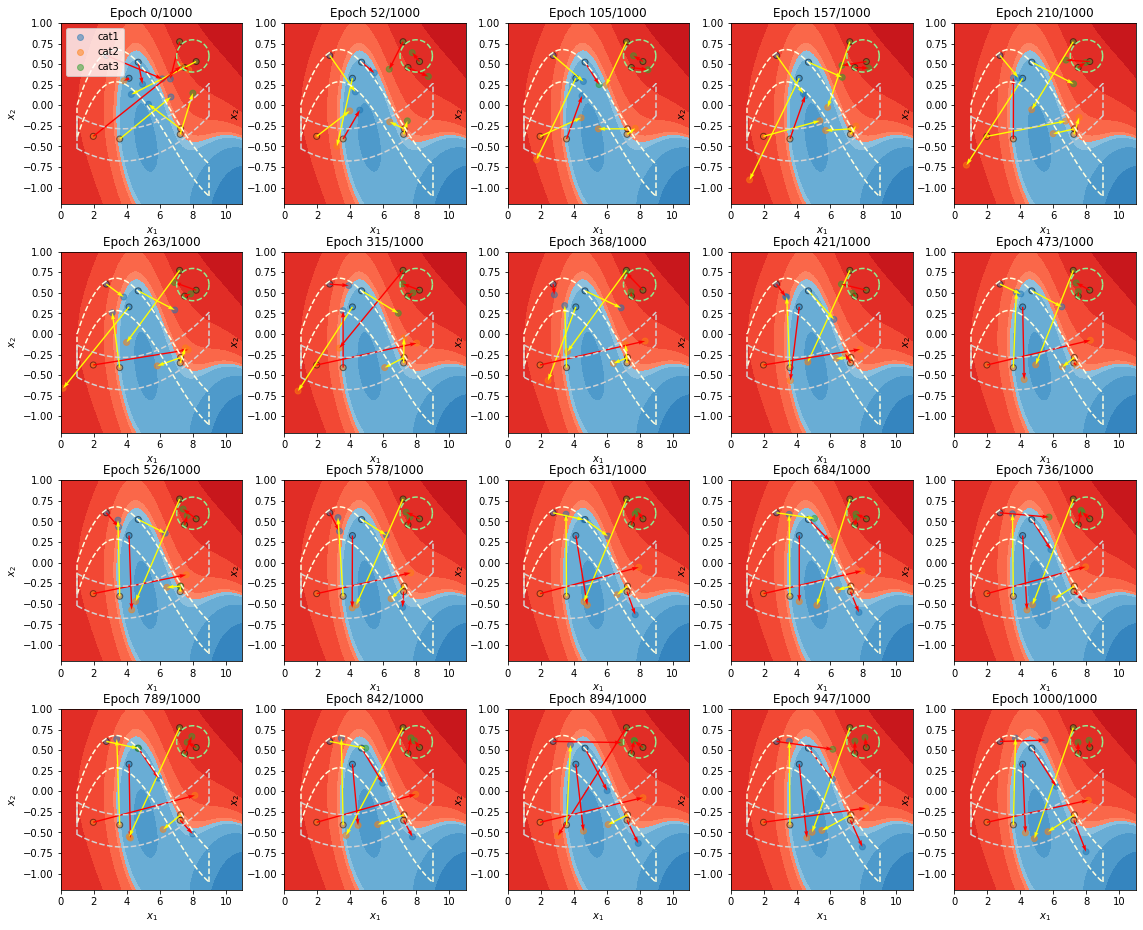

In [143]:
tgcf = TabGANcf(df_toy, classifier=classifier, n_critic = n_critic, opt_lr = opt_lr, adam_beta1 = adam_beta1,
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)
tgcf.train(n_epochs = 1000, batch_size = 500, restart_training = True, plot_loss_update_every = loss_plot_update_every,
             plot_loss_type = "line", progress_bar=True, plot2D_image_real_time=True,
              plot_loss = False, plot2D_n_test=10,
         plot2D_discrete_col="x3", save_dir = const.dir.images(), filename_plot2D = "syn2D_cf_plot2D.svg",
         filename_plot_loss = "syn2D_cf_train_loss.svg",
         plot2D_background_func = lambda ax : (plot_heatmap(ax, incl_colorbar = False, ret_contour = False),
                                               plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)))

In [61]:
queries_test = tgcf.generate_queries(5)
observations = tgcf.inv_data_transform(*tgcf.split_transformed_data(queries_test))
sampled_test = tgcf.sample_scaled(queries=queries_test)

In [63]:
tgcf.sample_scaled(queries=queries_test)

,x1,x2,x3:cat1,x3:cat2,x3:cat3
0,-0.055811,-0.784221,9.996825e-01,3.172627e-04,1.886582e-07
1,1.168070,1.269404,0.000000e+00,0.000000e+00,1.000000e+00
2,0.715492,1.410894,7.853129e-32,0.000000e+00,1.000000e+00
3,1.416742,-2.877208,1.000000e+00,5.186488e-23,2.501435e-26
4,0.770409,1.230509,1.264880e-16,2.386482e-14,1.000000e+00


In [58]:
classifier(observations)

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.82104857, 0.74240152, 0.23938885, 0.40132057, 0.52451399])>

In [59]:
classifier(sampled_test)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.73723495, 0.8206849 , 0.35668513, 0.5632053 , 0.3063007 ],
      dtype=float32)>

In [ ]:
classifier()

In [14]:
%lprun -f fast_non_dominated_sort a = tg.generate_counterfactuals(50, classifier, tg.data.loc[0], n_to_generate = 10000, add_plausibility_objective =True)

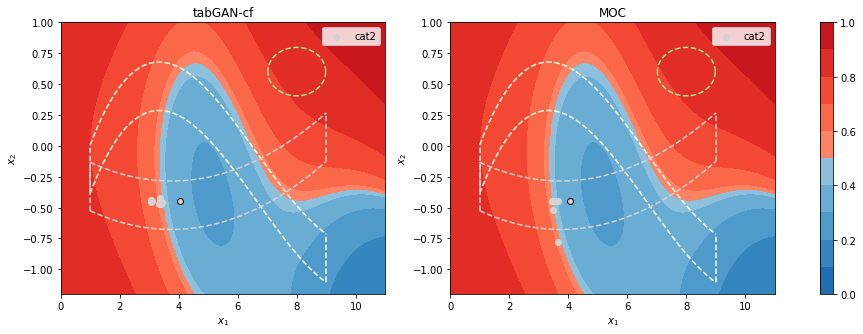

In [194]:
cf_dir = ".//Counterfactuals"
%run "$utils_path"
return_diff = False
compare_counterfactuals(df_toy, x_obs_nr = 89, save_path = "compare_counterfactuals_for_obs1.svg", save_dir=image_dir,
                       only_tabGAN_cf = False, figsize=[16,5])

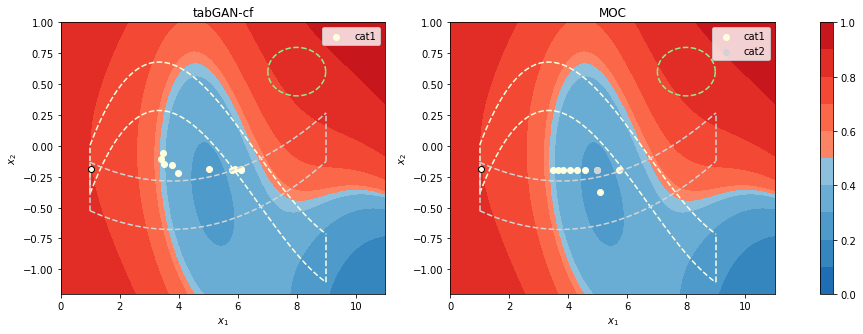

In [192]:
compare_counterfactuals(df_toy, x_obs_nr=243, save_path = "compare_counterfactuals_for_obs2.svg", save_dir=image_dir,
                       only_tabGAN_cf = False, figsize=[16,5])

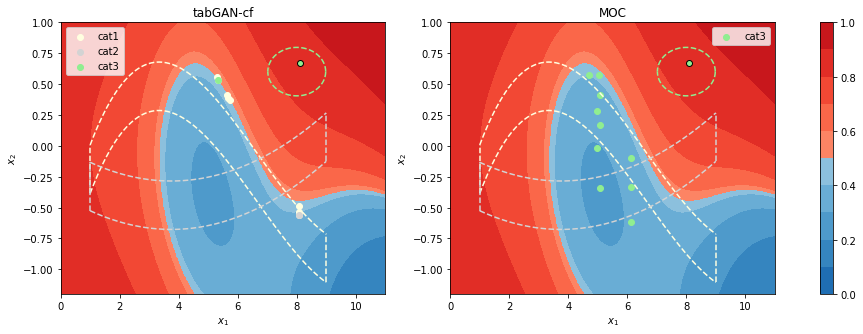

In [197]:
compare_counterfactuals(df_toy, x_obs_nr=11, save_path = "compare_counterfactuals_for_obs3.svg", save_dir=image_dir,
                       only_tabGAN_cf = False,figsize=[16,5])

In [102]:
print(df_toy.iloc[[89, 243, 11]].to_latex(index=False))

\begin{tabular}{rrl}
\toprule
      x1 &        x2 &   x3 \\
\midrule
4.049509 & -0.448952 & cat2 \\
1.038291 & -0.191824 & cat1 \\
8.107074 &  0.669967 & cat3 \\
\bottomrule
\end{tabular}



In [86]:
%run "$utils_path"
%run "$tableGAN_path"
data_adult_train= pd.read_csv('Datasets\\df_adult_edited_train.csv')
data_adult_test= pd.read_csv('Datasets\\df_adult_edited_test.csv')
discrete_columns = data_adult_train.columns[data_adult_train.dtypes == "object"]
data_adult_train[discrete_columns] = data_adult_train[discrete_columns].astype("category")
data_adult_test[discrete_columns] = data_adult_test[discrete_columns].astype("category")

data_adult_train_wo_income = data_adult_train.loc[:,data_adult_train.columns != "income"]

In [87]:
%run "$tableGAN_path"
tg_qt = TableGAN(data_adult_train_wo_income, n_critic = n_critic,
                 adam_lr = adam_lr, adam_beta1 = 0.5, adam_beta2 = 0.999,
              quantile_transformation_int = True, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

In [88]:
retrain = True
tic()
if retrain:
    tg_qt.train(n_epochs = 40, batch_size = 500, restart_training = True, loss_plot_update_every = loss_plot_update_every,
                 loss_plot_type = "line", progress_bar=True, plot_loss = False)
toc()

  0%|          | 0/40 [00:00<?, ?it/s]

Elapsed time: 212.471001 seconds.



In [89]:
clf = XGBClassifier(
        tree_method="gpu_hist", enable_categorical=True, use_label_encoder=True, eval_metric = "logloss"
    )

In [90]:
clf.fit(data_adult_train_wo_income, data_adult_train["income"])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              eval_metric='logloss', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [91]:
accuracy = accuracy_score(data_adult_test["income"],
                          clf.predict(data_adult_test.loc[:,data_adult_test.columns != "income"]))
auc = roc_auc_score(data_adult_test["income"],
                    clf.predict_proba(data_adult_test.loc[:,data_adult_test.columns != "income"])[:,1])
print("Accuracy:", accuracy)
print("AUC:", auc)

Accuracy: 0.8636786188579018
AUC: 0.9221461029691664


In [92]:
def pred_func(data):
    discrete_columns = data.columns[data.dtypes == "object"]
    data[discrete_columns] = data[discrete_columns].astype("category")
    return clf.predict_proba(data)[:,1]

In [93]:
print(data_adult_train.loc[0:0].to_latex(index=False))

\begin{tabular}{rlrlrllllrrrll}
\toprule
 age &  workclass &  fnlwgt & education &  educational.num & marital.status &   occupation &  race & gender &  capital.gain &  capital.loss &  hours.per.week & native.country & income \\
\midrule
  39 & Government &   77516 & Bachelors &               13 &  Never-married & Adm-clerical & White &   Male &          2174 &             0 &              40 &             US &  <=50K \\
\bottomrule
\end{tabular}



In [94]:
data_adult_train_wo_income.loc[0:0,]

,age,workclass,fnlwgt,education,educational.num,marital.status,occupation,race,gender,capital.gain,capital.loss,hours.per.week,native.country
0,39,Government,77516,Bachelors,13,Never-married,Adm-clerical,White,Male,2174,0,40,US


In [95]:
tic()
df_cf_explanations = tg_qt.generate_counterfactuals(3, pred_func, data_adult_train_wo_income.loc[0:0,], n_to_generate=100000,
                                                   epsilon_num_percent = 0.005)
toc()

Elapsed time: 25.052330 seconds.



In [96]:
df_cf_explanations["Prediction"] = pred_func(df_cf_explanations.loc[:,data_adult_train_wo_income.columns])
df_cf_explanations_transposed =df_cf_explanations.transpose()
df_cf_explanations_transposed.columns = [f"Observation {i+1}" for i in df_cf_explanations_transposed.columns]
df_cf_explanations_transposed

,Observation 1,Observation 2,Observation 3
age,42.0,40.0,39.0
workclass,Government,Government,Government
fnlwgt,76045.65625,37550.546875,150997.953125
education,Bachelors,Bachelors,Bachelors
educational.num,13.0,13.0,13.0
marital.status,Married,Married,Married
occupation,Adm-clerical,Adm-clerical,Adm-clerical
race,White,White,White
gender,Male,Male,Male
capital.gain,0.0,0.0,0.0


In [97]:
print(df_cf_explanations_transposed.to_latex())

\begin{tabular}{llll}
\toprule
{} & Observation 1 & Observation 2 &  Observation 3 \\
\midrule
age             &          42.0 &          40.0 &           39.0 \\
workclass       &    Government &    Government &     Government \\
fnlwgt          &   76045.65625 &  37550.546875 &  150997.953125 \\
education       &     Bachelors &     Bachelors &      Bachelors \\
educational.num &          13.0 &          13.0 &           13.0 \\
marital.status  &       Married &       Married &        Married \\
occupation      &  Adm-clerical &  Adm-clerical &   Adm-clerical \\
race            &         White &         White &          White \\
gender          &          Male &          Male &           Male \\
capital.gain    &           0.0 &           0.0 &            0.0 \\
capital.loss    &           0.0 &           0.0 &            0.0 \\
hours.per.week  &          40.0 &          40.0 &           40.0 \\
native.country  &            US &            US &             US \\
Gower distance  &    